In [1]:
# Notes:
# Things to try out:
#     - add regularization (weight decay for L2) -
#     - increase batch size
#     - xavier/2 weight init for new front/ deep layers -
#     - freeze conv layers of vgg -

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms as T

# from source_code.classifiers.segmentation_nn import SegmentationNN
from source_code.classifiers.fcn32s import FCN32s
from source_code.data_utils import SegmentationData, label_img_to_rgb

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
num_images = 394.0
num_train_images = 276.0
std = torch.tensor([0.3769369 , 0.36186826, 0.36188436], dtype=torch.float32)
mu = torch.tensor([0.6353146 , 0.6300146 , 0.52398586], dtype=torch.float32)
unnormalize = T.Normalize((-mu/std).tolist(), (1.0/std).tolist())
class_px_freq = [2285972., 3871883., 2026843.,  815020.,   29847.,  635062.,
       1967281.,  224552.,  362101., 1631062.,  513175.,  899341.,
        683883.,  806298.,  691964.,  358394., 1242311.,  529301.,
       1706232.,  456055.,  491802.,  599859.,  253551.]
train_class_px_freq = [1062509., 1681379.,  954679.,  404714.,       0.01,  283741.,
        923550.,  121971.,  184074.,  807761.,  242641.,  416824.,
        326218.,  337662.,  252980.,  180717.,  568425.,  226895.,
        854037.,  232267.,  192601.,  289468.,   85268.]
class_px_mean = np.asarray(class_px_freq)/num_images
train_class_px_mean = np.asarray(train_class_px_freq)/num_train_images
class_weight = 1.0/class_px_mean
train_class_weight = 1.0/train_class_px_mean
# Only use when over-fitting on entire dataset
# W = torch.tensor(class_weight).float()
# W = W.cuda()
W = torch.tensor(train_class_weight).float()
if (torch.cuda.is_available()):
    W = W.cuda()

In [4]:
def smooth(list, degree=10):
     window=degree*2-1
     weight=np.array([1.0]*window)  
     weightGauss=[]

     for i in range(window):  
         i=i-degree+1
         frac=i/float(window)  
         gauss=1/(np.exp((4*(frac))**2))  
         weightGauss.append(gauss)  

     weight=np.array(weightGauss)*weight  
     smoothed=[0.0]*(len(list)-window)  

     for i in range(len(smoothed)):  
         smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
     return smoothed

# Train & Validation Data

In [5]:
train_data = SegmentationData(image_paths_file='datasets/segmentation_data/t.txt')
val_data = SegmentationData(image_paths_file='datasets/segmentation_data/v.txt')
test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/test.txt')
# test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/single_sample.txt')

Train size: 1
Validation size: 1
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


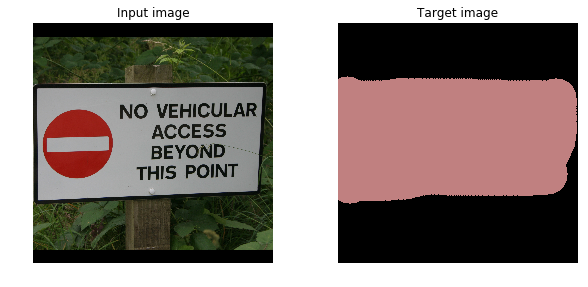

In [6]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(unnormalize(img).numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    # plt.imshow(label_img_to_rgb(target.numpy()))
    plt.imshow(label_img_to_rgb(target.numpy())) ###
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [7]:
# print("Train size: %i" % len(train_data))
# print("Validation size: %i" % len(val_data))
# print("Img size: ", train_data[0][0].size())
# print("Segmentation size: ", train_data[0][1].size())

# num_example_imgs = 3
# plt.figure(figsize=(10, 5 * num_example_imgs))
# for i, (img, target) in enumerate(train_data[:num_example_imgs]):
#     # img
#     plt.subplot(num_example_imgs, 2, i * 2 + 1)
#     plt.imshow(img.numpy().transpose(1,2,0))
#     plt.axis('off')
#     if i == 0:
#         plt.title("Input image")
    
#     # target
#     plt.subplot(num_example_imgs, 2, i * 2 + 2)
#     # plt.imshow(label_img_to_rgb(target.numpy()))
#     plt.imshow(label_img_to_rgb(target.numpy())) ###
#     plt.axis('off')
#     if i == 0:
#         plt.title("Target image")
# plt.show()

# Normalize data and find pixel-wise distribution

In [7]:
SEG_LABELS_LIST = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

In [9]:
tpop_mean = []
tpop_std0 = []

vpop_mean = []
vpop_std0 = []

ttpop_mean = []
ttpop_std0 = []

freq = np.zeros(23)

for i, (img, target) in enumerate(train_data):
    # print(i)
    numpy_image = img.numpy()
    tbatch_mean = np.mean(numpy_image, axis=(1, 2))
    # print(batch_mean.shape)
    tbatch_std0 = np.std(numpy_image, axis=(1, 2))
    # batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    for label in SEG_LABELS_LIST:
        mask = (target.numpy() == label['id'])
#         print(mask)
        if (label['id'] > -1):
            freq[label['id']] += np.sum(mask)
    
    tpop_mean.append(tbatch_mean)
    tpop_std0.append(tbatch_std0)
    # pop_std1.append(batch_std1)
#     if i > 0:
#         break

for i, (img, target) in enumerate(val_data):
    # print(i)
    numpy_image = img.numpy()
    # print(numpy_image.shape)
    vbatch_mean = np.mean(numpy_image, axis=(1, 2))
    # print(batch_mean.shape)
    vbatch_std0 = np.std(numpy_image, axis=(1, 2))
    # batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    for label in SEG_LABELS_LIST:
        mask = (target.numpy() == label['id'])
#         print(mask)
        if (label['id'] > 0):
            freq[label['id']] += np.sum(mask)    
    
    vpop_mean.append(vbatch_mean)
    vpop_std0.append(vbatch_std0)
    # pop_std1.append(batch_std1)
#     if i > 0:
#         break

for i, (img, target) in enumerate(test_data):
    # print(i)
    numpy_image = img.numpy()
    # print(numpy_image.shape)
    ttbatch_mean = np.mean(numpy_image, axis=(1, 2))
    # print(batch_mean.shape)
    ttbatch_std0 = np.std(numpy_image, axis=(1, 2))
    # batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    for label in SEG_LABELS_LIST:
        mask = (target.numpy() == label['id'])
#         print(mask)
        if (label['id'] > 0):
            freq[label['id']] += np.sum(mask)
    ttpop_mean.append(ttbatch_mean)
    ttpop_std0.append(ttbatch_std0)
    # pop_std1.append(batch_std1)
#     if i > 0:
#         break            
    
tpop_mean = np.array(tpop_mean).mean(axis=0)
tpop_std0 = np.array(tpop_std0).mean(axis=0)

vpop_mean = np.array(vpop_mean).mean(axis=0)
vpop_std0 = np.array(vpop_std0).mean(axis=0)

ttpop_mean = np.array(ttpop_mean).mean(axis=0)
ttpop_std0 = np.array(ttpop_std0).mean(axis=0)

mean = (tpop_mean + vpop_mean + ttpop_mean)/2
std0 = (tpop_std0 + vpop_std0 + ttpop_std0)/2
# pop_std1 = np.array(pop_std1).mean(axis=0)

In [10]:
std0

array([0.8524494, 0.8596698, 0.9095127], dtype=float32)

# Train Your Network

In [8]:
# from source_code.classifiers.segmentation_nn import SegmentationNN
# from source_code.solver import Solver
from source_code.classifiers.fcn32s import FCN32s
import torch.nn.functional as F
import torchvision.models as model_set


########################################################################
#                             YOUR CODE                                #
########################################################################

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True, num_workers=2)

# model = SegmentationNN().cuda()
# model = SegmentationNN()
model = FCN32s(23)

model.copy_params_from_vgg16(model_set.vgg11(pretrained=True))
if (torch.cuda.is_available()):
    model = model.cuda()

In [9]:
##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
from source_code.my_solver import Solver

solver = Solver(loss_func=torch.nn.CrossEntropyLoss(weight=W, ignore_index=-1))
#solver = Solver(loss_func=torch.nn.CrossEntropyLoss(ignore_index=-1))
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [18]:
# lr_grid = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
lr_grid = [1e-6]
top_acc = 0.0
top_lr = 0.0
val_acc = []

for lr in lr_grid:
    solver.optim_args['lr'] = lr
    acc = solver.train(model, train_loader, val_loader, num_epochs=1, log_nth=1)
    val_acc.append(acc)
    if val_acc[-1:]:
        if val_acc[-1:] < acc:
            top_acc = acc
            top_lr = lr
    else:
        top_acc = acc
        top_lr = lr
    print("Ler. Rate: "+str(lr)+" Val. Acc: "+str(acc))

START TRAIN.


KeyboardInterrupt: 

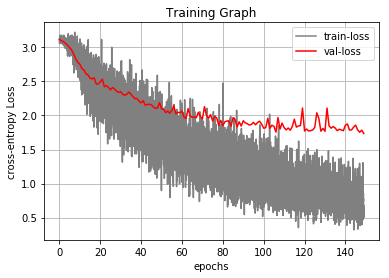

In [46]:
fig, ax = plt.subplots()

# plt.plot(solver.train_loss_history, 'b')
x_val = [x*0.0036 for x in range(1, len(smooth(solver.train_loss_history))+1)]
plt.plot(x_val, smooth(solver.train_loss_history, 10), 'grey')
plt.plot(solver.val_loss_history, 'r')
plt.title('Training Graph')
plt.xlabel('epochs')
plt.ylabel('cross-entropy Loss')
plt.legend(['train-loss', 'val-loss'])
plt.grid(True)

In [47]:
plt.savefig('train-graph-lr1e-6-150epoc.eps', format='eps', dpi=1200)

In [9]:
import pickle


filehandler = open('solver-lr1e-6-150epoc.obj', 'wb')
pickle.dump(solver, filehandler)

NameError: name 'solver' is not defined

# Test Your Model

In [7]:
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=1)

In [18]:
test_scores = []
model.eval()
for inputs, targets in test_loader:
    # inputs, targets = Variable(inputs), Variable(targets)
    # if model.is_cuda:
    inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

0.6002702042649467

Load Model

In [17]:
import pickle
from source_code.classifiers.fcn32s import FCN32s
import torch.nn.functional as F
import torchvision.models as model_set
from source_code.my_solver import Solver





filehandler = open('solver-lr1e-6-150epoc.obj', 'rb')
solver=pickle.load(filehandler)
# model = torch.load('mymodel')
# self.model = model.cpu().double()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [8]:
import pickle
from source_code.classifiers.fcn32s import FCN32s
import torch.nn.functional as F
import torchvision.models as model_set
from source_code.my_solver import Solver

model2 = torch.load('models/fcn32s-lr1e-6-150epoc.model', map_location='cpu')
model2 = model2.cpu()

E:\Program_Files\Anaconda3\envs\I2DL\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
E:\Program_Files\Anaconda3\envs\I2DL\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
E:\Program_Files\Anaconda3\envs\I2DL\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by ac

In [9]:
model2 = FCN32s(23)
model2.load_state_dict(model.state_dict())

(240, 240)
(240, 240)


NameError: name 'model' is not defined

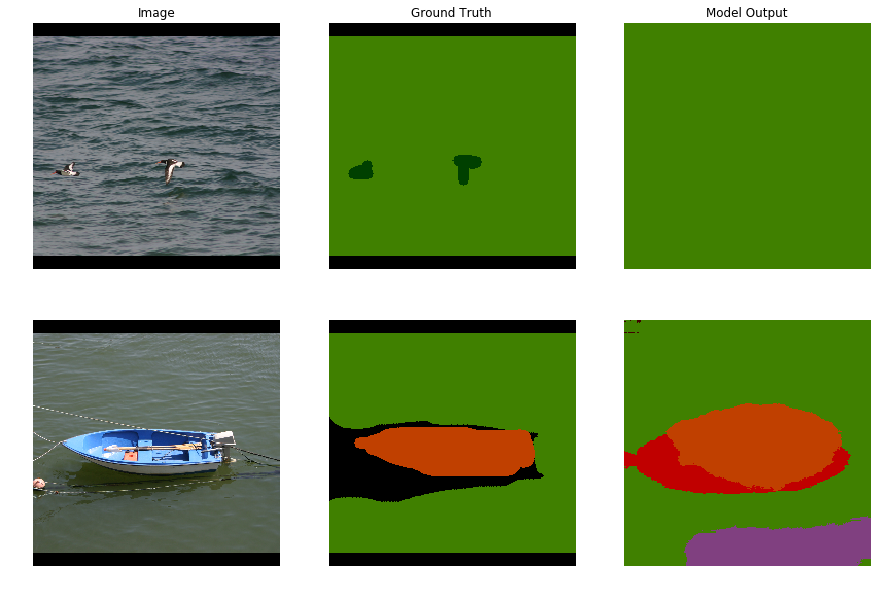

In [9]:
num_example_imgs = 2
# model.eval()
plt.figure(figsize=(15, 5 * num_example_imgs))
model2.eval()
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    # if model.is_cuda:
    inputs = inputs.float()
    
    outputs = model2.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = unnormalize(img).numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Ground Truth")
    
    print(pred.shape)
    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Model Output")
# model.train()
model.train()
plt.show()

# Visualization

In [13]:
num_example_imgs = 1
# model.eval()
plt.figure(figsize=(15, 5 * num_example_imgs))
model2.eval()
model=model
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    # if model.is_cuda:
    inputs = inputs.float()
    
    outputs = model2.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = unnormalize(img).numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Ground Truth")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Model Output")
# model.train()
model.train()
plt.show()

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'weight'

In [67]:
plt.savefig('test-samp-lr1e-6-150epoc.eps', format='eps', dpi=1200)

# Visualize Filter Weights

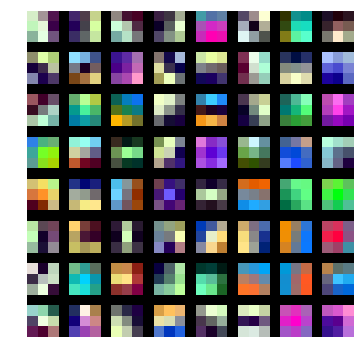

In [20]:
from source_code.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Save Model

In [21]:
model.save("models/fcn32s-lr1e-6-150epoc.model")

Saving model... models/fcn32s-lr1e-6-150epoc.model
